In [1]:
import numpy as np

In [2]:
np.random.seed(21)

In [3]:
import scipy.stats as st
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D, Flatten, Dense, Lambda
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.losses import mean_squared_error, mean_absolute_error, categorical_crossentropy, binary_crossentropy
from keras.preprocessing.image import Iterator
import matplotlib.pyplot as plt
import cv2
import os
import json
import pickle
%matplotlib inline

from keras.utils.np_utils import to_categorical

from keras.layers import Reshape, BatchNormalization

import tensorflow as tf
sess = tf.Session()
K.set_session(sess)

Using TensorFlow backend.


In [28]:
from __future__ import absolute_import
from __future__ import print_function

from pkg_resources import parse_version
from keras.callbacks import Callback

In [29]:
class TensorBoardCallBack(Callback):
    """Tensorboard basic visualizations.
    This callback writes a log for TensorBoard, which allows
    you to visualize dynamic graphs of your training and test
    metrics, as well as activation histograms for the different
    layers in your model.
    TensorBoard is a visualization tool provided with TensorFlow.
    If you have installed TensorFlow with pip, you should be able
    to launch TensorBoard from the command line:
    ```
    tensorboard --logdir=/full_path_to_your_logs
    ```
    You can find more information about TensorBoard
    [here](https://www.tensorflow.org/versions/master/how_tos/summaries_and_tensorboard/index.html).
    # Arguments
        log_dir: the path of the directory where to save the log
            files to be parsed by Tensorboard
        batch_freq: frequency (in batch) at which to log data
            If set to 0, we just log at the end of an epoch,
    """

    def __init__(self, log_dir='./logs',
                 batch_freq=0):
        super(TensorBoardCallBack, self).__init__()

        self.log_dir = log_dir
        self.batch_freq = batch_freq
        self.merged = None
        self.writer = tf.summary.FileWriter(self.log_dir)
        self.last_batch = 0
        self.batch_offset = 0

    def set_model(self, model):
        self.model = model
        self.sess = K.get_session()

        if hasattr(tf, 'merge_all_summaries'):
            self.merged = tf.merge_all_summaries()
        else:
            self.merged = tf.summary.merge_all()

    def on_batch_end(self, batch, logs=None):
        # Each time we go back to batch 0, we increase the batch_offset
        if batch < self.last_batch:
            self.batch_offset += self.last_batch + 1
        self.last_batch = batch

        batch_cross_epoch = self.batch_offset + batch
        if batch_cross_epoch % self.batch_freq == 0:
            logs = logs or {}

            for name, value in logs.items():
                if name in ['batch', 'size']:
                    continue
                summary = tf.Summary()
                summary_value = summary.value.add()
                summary_value.simple_value = value.item()
                summary_value.tag = name
                self.writer.add_summary(summary, batch_cross_epoch)
            self.writer.flush()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for name, value in logs.items():
            if name in ['batch', 'size']:
                continue
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.writer.add_summary(summary, epoch)
        self.writer.flush()

    def on_train_end(self, _):
        self.writer.close()

In [327]:
from keras.applications.resnet50 import ResNet50

In [328]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(None, None, 3))

In [329]:
h = base_model.layers[-2]
pups_prediction = Conv2D(1, (2, 2), activation="sigmoid")(h.output)

In [330]:
pups_net = Model(inputs=[base_model.input], outputs=[pups_prediction])

In [331]:
pups_net.predict(np.ones((1, 48, 48, 3))).shape

(1, 1, 1, 1)

In [332]:
pups_net.predict(np.ones((1, 224, 224, 3))).shape

(1, 6, 6, 1)

In [333]:
pups_net.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D) (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, None, None, 64 9472                                         
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, None, None, 64 256                                          
___________________________________________________________________________________________

In [39]:
class NonValidPatch(Exception):
    pass

In [40]:
def get_block_loc(shape, x, y, target_size=(224, 224), n_blocks=(4,4), overlap=(448,448)):
    h, w = shape
    w_block = (w + (n_blocks[1] - 1) * overlap[1]) // n_blocks[1]
    h_block = (h + (n_blocks[0] - 1) * overlap[0]) // n_blocks[0]
    for by in range(n_blocks[0]):
        y_start = by * (h_block - overlap[0])
        y_end = y_start + h_block + 1
        for bx in range(n_blocks[1]):
            x_start = bx * (w_block - overlap[1])
            x_end = x_start + w_block + 1
            
            if x_start <= x < x_end and y_start <= y < y_end and\
            x_start <= x + target_size[1] - 1 < x_end and y_start <= y + target_size[0] - 1 < y_end:
                return bx + by * n_blocks[0], x - x_start, y - y_start
    raise NonValidPatch("Can't find block...??")

In [389]:
class PupsIterator(Iterator):
    """Iterator yielding training samples of pups
    :param root_dir: Directory containing training images, and dots.
    :param image_ids: Set of image ids to use to sample patches.
    :param class_weights: Weights for each class.
    :param n_samples_per_image: Number of patches to sample on each image.
    :param target_size: Size of the patches sampled.
    :param batch_size: Number of patches sampled per batch
    :param shuffle: Boolean, whether to shuffle the data between epochs.
    :param seed: Random seed for data shuffling.
    :return batch_x, batch_x. 
        batch_x is a (batch_size, target_size[0], target_size[1], 3) array
        batch_x is a (batch_size, target_size[0], target_size[1], 1) array if output_counts is False
        otherwise, it is a (batch_size, 5) array.
    """

    def __init__(self, root_dir, image_ids,
                 class_weights = None,
                 n_samples_per_image=160,
                 target_size=(48, 48),
                 batch_size=64, shuffle=True, seed=42, debug_dir=None):
        self.n_samples_per_block = 16
        self.n_sealion_types = 5
        self.image_ids = image_ids
        self.root_dir = root_dir
        self.debug_dir = debug_dir
        # Normalize to use class_weights as a probability distribution.
        if class_weights:
            self.class_weights = np.asarray(class_weights)/np.sum(class_weights)
        else:
            self.class_weights = np.ones((self.n_sealion_types+1))/(self.n_sealion_types + 1)
            
        self.n_samples_per_image = n_samples_per_image
        self.target_size = target_size
        self.n_indices = len(self.image_ids) * self.n_samples_per_image
                 
        super(PupsIterator, self).__init__(self.n_indices, batch_size//self.n_samples_per_block, shuffle, seed)
    
    def normalize_input(self, x_bgr):
        x = x_bgr.copy()
        x[..., 0] -= 103.939
        x[..., 1] -= 116.779
        x[..., 2] -= 123.68
        return x
    
    def denormalize_input(self, x_normed):
        x = x_normed.copy()
        x[..., 0] += 103.939
        x[..., 1] += 116.779
        x[..., 2] += 123.68
        return x

    def random_transform(self, im):
        flip_hor = np.random.randint(0, 2)
        flip_ver = np.random.randint(0, 2)
        if flip_hor == 1:
            im = cv2.flip(im, 0)
        if flip_ver == 1:
            im = cv2.flip(im, 1)
        return im
    
    def get_weights(self, dots):
        # Set probability to 0 if some sealion type is not in the block
        current_weigths = self.class_weights.copy()
        for i in range(self.n_sealion_types):
            if not dots[i]:
                current_weigths[i] = 0
        current_weigths /= np.sum(current_weigths)
        return current_weigths
    
    def sample_position(self, shape, dots, current_weigths):
        # Choose an output class randomly
        output_class = np.random.choice(self.n_sealion_types + 1, size=(1, ), p=current_weigths)[0]
        # Sample a location, either for background or for a sealion.
        if output_class == self.n_sealion_types:
            # avoid bg with pups in it
            return self.sample_bg(shape, dots[4]), output_class
        else:
            return self.sample_dot(shape, dots[output_class]), output_class

    def get_dots_in_block(self, bid, shape, dots, target_size=(224, 224), n_blocks=(4,4), overlap=(448,448)):
        h, w = shape
        w_block = (w + (n_blocks[1] - 1) * overlap[1]) // n_blocks[1]
        h_block = (h + (n_blocks[0] - 1) * overlap[0]) // n_blocks[0]
        
        bx = bid % n_blocks[0]
        by = bid // n_blocks[0]
        
        y_start = by * (h_block - overlap[0])
        y_end = y_start + h_block + 1
        x_start = bx * (w_block - overlap[1])
        x_end = x_start + w_block + 1
        
        dots_in_block = [[] for _ in range(self.n_sealion_types)]
        for i, ds in enumerate(dots):
            for (x, y) in ds:
                if x_start <= x < x_end and y_start <= y < y_end:
                    dots_in_block[i].append((x - x_start, y - y_start))
        return dots_in_block
        
    def get_random_block(self, image_id, shape, dots, current_weigths):
        while True:
            try:
                (x, y), output_class = self.sample_position(shape, dots, current_weigths)
                
                # Get the corresponding image block, and (x, y) in this block
                bid, x, y = get_block_loc(shape, x, y)
                
                # Load the block and check if it is valid
                uid = "{iid}_{bid}".format(iid=image_id, bid=bid)
                img = cv2.imread(os.path.join(self.root_dir, "TrainBlock", uid + ".jpg"))
                if img is not None:
                    return bid, img
            except NonValidPatch:
                continue
        
    
    def sample(self, shape, dots, image_id):
        # if more than 30% of the patch is masked, reject it
        threshold_masked = 0.3 
        
        # If we are stuck on a "bad" block, we retry from scratch
        while True:
            # Set probability to 0 if some sealion type is not in the block
            current_weigths = self.get_weights(dots)
        
            # Get a block randomly (but using the dots and the sampling weights)
            bid, img = self.get_random_block(image_id, shape, dots, current_weigths)
                
            # Recompute dots in the blocks, and sampling weights
            dots_block = self.get_dots_in_block(bid, shape, dots)
            current_weigths = self.get_weights(dots_block)

            # Now, sample n_samples_per_block patches from it
            n_samples = 0
            bx = np.zeros((self.n_samples_per_block, self.target_size[0], self.target_size[1], 3))
            by = np.zeros((self.n_samples_per_block, ))

            # Stop if we try too many times, 
            max_iterations = self.n_samples_per_block * 5
            current_iteration = 0
            while n_samples < self.n_samples_per_block and current_iteration < max_iterations:
                current_iteration += 1
                try:
                    (x, y), output_class = self.sample_position(img.shape[:2], dots_block, current_weigths)
                    img_patch = img[y:y+self.target_size[0], x:x+self.target_size[1],:]
                    masked_pixels = np.count_nonzero(img_patch == 0)
                    total_pixels = img_patch.shape[0] * img_patch.shape[1]
                    if img_patch.shape[0] != self.target_size[0] or img_patch.shape[1] != self.target_size[1]:
                        continue
                    if masked_pixels/total_pixels < threshold_masked:
                        bx[n_samples, ...] = self.random_transform(img_patch)
                        by[n_samples] = 1 if output_class==4 else 0
                        n_samples += 1
                except NonValidPatch:
                    continue
                    
            if current_iteration < max_iterations:
                return bx, by
            # else, we tried too many times, let's get another block.
        
        
    def contains_dots(self, xstart, ystart, dots, margin):
        x1 = xstart - margin
        y1 = ystart - margin
        x2 = xstart + self.target_size[1] + margin
        y2 = ystart + self.target_size[0] + margin
        for (x, y) in dots:
            if x1 <= x < x2 and y1 <= y < y2:
                return True
        return False
    
    def sample_bg(self, shape, dots):
        margin = 16
        max_iterations = 10
        current_iteration = 0
        while current_iteration < max_iterations:
            x = np.random.randint(0, shape[1] - self.target_size[1], size=(1,))[0]
            y = np.random.randint(0, shape[0] - self.target_size[0], size=(1,))[0]
            if not self.contains_dots(x, y, dots, margin):
                return x, y
            current_iteration += 1
        raise NonValidPatch("Cant' find background")
    
    def sample_dot(self, shape, dots):
        margin = self.target_size[0]//8
        
        rand_index = np.random.choice(len(dots), size=(1,))[0]
        rand_dot = dots[rand_index]
        
        min_x = max(0, rand_dot[0] - self.target_size[1]//2 - margin)
        max_x = min(shape[1] - self.target_size[1], rand_dot[0] - self.target_size[1]//2 + margin)
        
        min_y = max(0, rand_dot[1] - self.target_size[0]//2 - margin)
        max_y = min(shape[0] - self.target_size[0], rand_dot[1] - self.target_size[0]//2 + margin)
        
        if min_x > max_x:
            max_x, min_x = min_x, max_x
        if min_y > max_y:
            max_y, min_y = min_y, max_y 
            
        if min_x == max_x or min_y == max_y:
            raise NonValidPatch()
           
        x = np.random.randint(min_x, max_x, size=(1,))[0]
        y = np.random.randint(min_y, max_y, size=(1,))[0]
        
        return x, y
        
    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
                
        batch_x = np.zeros((current_batch_size * self.n_samples_per_block, self.target_size[0], self.target_size[1], 3), dtype=K.floatx())
        batch_y = np.zeros((current_batch_size * self.n_samples_per_block), dtype=np.int32)
        
        # For each index, we load the data and sample randomly n_successive_samples patches
        for i, j in enumerate(index_array):
            index = j // self.n_samples_per_image
            image_id = self.image_ids[index]
            with open(os.path.join(self.root_dir, "TrainDots", str(image_id) + ".pkl"), "rb") as pfile:
                dots = pickle.load(pfile)
            with open(os.path.join(self.root_dir, "TrainShape", str(image_id) + ".pkl"), "rb") as pfile:
                shape = pickle.load(pfile)
                
            x, y = self.sample(shape, dots, image_id)
            batch_x[i*self.n_samples_per_block:(i+1)*self.n_samples_per_block, ...] = x
            batch_y[i*self.n_samples_per_block:(i+1)*self.n_samples_per_block] = y 

        if self.debug_dir:
            for i in range(current_batch_size):
                cv2.imwrite(os.path.join(self.debug_dir, "patch_{}.jpg".format(i)), batch_x[i])
                
        permut = np.random.permutation(batch_x.shape[0])
        return self.normalize_input(batch_x[permut, ...]), batch_y[permut,...].reshape((-1, 1, 1, 1))

In [390]:
with open("../data/train.json", "r") as jfile:
    train_ids = json.load(jfile)
train_ids = [int(iid) for iid in train_ids]

with open("../data/val.json", "r") as jfile:
    val_ids = json.load(jfile)
val_ids = [int(iid) for iid in val_ids]

In [391]:
class_weights = [0.25,  0.25, 0.25, 0.25, 2.0, 0.1]

In [415]:
trainPupsGenerator = PupsIterator("/home/ubuntu/sealion/data/", train_ids, class_weights=class_weights)

valPupsGenerator = PupsIterator("/home/ubuntu/sealion/data/", val_ids, class_weights=class_weights)

In [422]:
for i, (batch_x, batch_y) in enumerate(trainPupsGenerator):
    break

In [423]:
batch_y.ravel()

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1], dtype=int32)

In [424]:
pups_net.predict(batch_x).shape

(64, 1, 1, 1)

In [425]:
for layer in base_model.layers:
    layer.trainable = False

In [426]:
from keras.losses import binary_crossentropy

In [427]:
sgd = SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=True)
pups_net.compile(optimizer=sgd, loss=binary_crossentropy, metrics=['accuracy'])

In [428]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

cb_checkpoint = ModelCheckpoint("/home/ubuntu/data/sealion/data/models/class_pups/ckpt_{epoch:02d}-{val_loss:.2f}.h5")
cb_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', epsilon=0.001, cooldown=0, min_lr=0)
tensorboard_cb = TensorBoardCallBack(log_dir="/home/ubuntu/data/sealion/data/models/class_pups/log_tb", batch_freq=10)

In [429]:
h = pups_net.fit_generator(trainPupsGenerator, 1000, epochs=20,
                           verbose=1, callbacks=[cb_checkpoint, cb_reduce_lr, tensorboard_cb],
                           validation_data=valPupsGenerator, validation_steps=200,
                           class_weight=None,
                           max_q_size=16, workers=4, pickle_safe=False,
                           initial_epoch=0)

Epoch 1/20
1000/1000 [==============================] - 272s - loss: 1.5985 - acc: 0.8094 - val_loss: 1.4113 - val_acc: 0.8656
Epoch 2/20
1000/1000 [==============================] - 174s - loss: 1.3317 - acc: 0.8349 - val_loss: 1.0982 - val_acc: 0.8586
Epoch 3/20
1000/1000 [==============================] - 165s - loss: 1.1853 - acc: 0.8374 - val_loss: 0.9628 - val_acc: 0.8585
Epoch 4/20
1000/1000 [==============================] - 160s - loss: 1.0554 - acc: 0.8407 - val_loss: 0.9113 - val_acc: 0.8765
Epoch 5/20
1000/1000 [==============================] - 157s - loss: 0.9482 - acc: 0.8380 - val_loss: 0.7194 - val_acc: 0.8807
Epoch 6/20
1000/1000 [==============================] - 155s - loss: 0.8391 - acc: 0.8426 - val_loss: 0.6319 - val_acc: 0.8805
Epoch 7/20
1000/1000 [==============================] - 154s - loss: 0.7561 - acc: 0.8425 - val_loss: 0.6363 - val_acc: 0.8688
Epoch 8/20
1000/1000 [==============================] - 154s - loss: 0.6996 - acc: 0.8408 - val_loss: 0.5696 - 

In [544]:
im_val = cv2.imread("/home/ubuntu/sealion/data/TrainBlock/43_5.jpg")

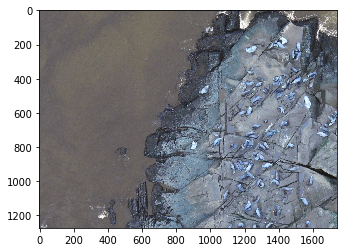

In [545]:
plt.imshow(im_val)

In [546]:
im_val.shape

(1273, 1741, 3)

In [577]:
22*48

1056

In [584]:
im_val_patch = im_val[:48*22, -1056:, :]

im_val_patch = im_val_patch.reshape((1, 48*22, 1056, 3))

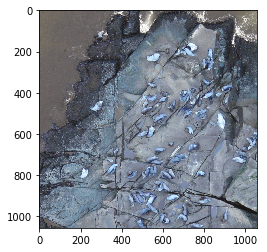

In [586]:
plt.imshow(im_val_patch[0,...])

In [592]:
im_val_pred = pups_net.predict(trainPupsGenerator.normalize_input(im_val_patch.astype(np.float32)))

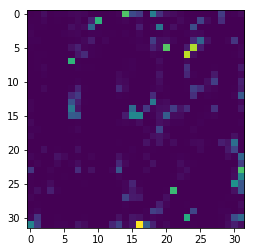

In [593]:
plt.imshow(im_val_pred[0,:,:,0])

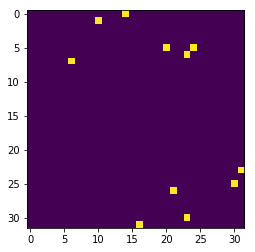

In [594]:
im_val_pred_pups = im_val_pred > 0.5
plt.imshow(im_val_pred_pups[0,:,:,0])

In [595]:
for i, l in enumerate(base_model.layers):
    print(i, l.name)

0 input_3
1 zero_padding2d_3
2 conv1
3 bn_conv1
4 activation_99
5 max_pooling2d_3
6 res2a_branch2a
7 bn2a_branch2a
8 activation_100
9 res2a_branch2b
10 bn2a_branch2b
11 activation_101
12 res2a_branch2c
13 res2a_branch1
14 bn2a_branch2c
15 bn2a_branch1
16 add_33
17 activation_102
18 res2b_branch2a
19 bn2b_branch2a
20 activation_103
21 res2b_branch2b
22 bn2b_branch2b
23 activation_104
24 res2b_branch2c
25 bn2b_branch2c
26 add_34
27 activation_105
28 res2c_branch2a
29 bn2c_branch2a
30 activation_106
31 res2c_branch2b
32 bn2c_branch2b
33 activation_107
34 res2c_branch2c
35 bn2c_branch2c
36 add_35
37 activation_108
38 res3a_branch2a
39 bn3a_branch2a
40 activation_109
41 res3a_branch2b
42 bn3a_branch2b
43 activation_110
44 res3a_branch2c
45 res3a_branch1
46 bn3a_branch2c
47 bn3a_branch1
48 add_36
49 activation_111
50 res3b_branch2a
51 bn3b_branch2a
52 activation_112
53 res3b_branch2b
54 bn3b_branch2b
55 activation_113
56 res3b_branch2c
57 bn3b_branch2c
58 add_37
59 activation_114
60 res3c_br

In [528]:
for l in base_model.layers[141:]:
    l.Trainable = True

In [ ]:
sgd = SGD(lr=0.0001, momentum=0.9, decay=0.0005, nesterov=True)
pups_net.compile(optimizer=sgd, loss=binary_crossentropy, metrics=['accuracy'])

In [529]:
h = pups_net.fit_generator(trainPupsGenerator, 1000, epochs=20,
                           verbose=1, callbacks=[cb_checkpoint, cb_reduce_lr, tensorboard_cb],
                           validation_data=valPupsGenerator, validation_steps=200,
                           class_weight=None,
                           max_q_size=16, workers=4, pickle_safe=False,
                           initial_epoch=0)

Epoch 1/20
1000/1000 [==============================] - 150s - loss: 0.4013 - acc: 0.8487 - val_loss: 0.3625 - val_acc: 0.8647
Epoch 2/20
1000/1000 [==============================] - 149s - loss: 0.3913 - acc: 0.8509 - val_loss: 0.2937 - val_acc: 0.8936
Epoch 3/20
1000/1000 [==============================] - 149s - loss: 0.3775 - acc: 0.8549 - val_loss: 0.3111 - val_acc: 0.8838
Epoch 4/20
1000/1000 [==============================] - 150s - loss: 0.3766 - acc: 0.8532 - val_loss: 0.3836 - val_acc: 0.8716
Epoch 5/20
 999/1000 [============================>.] - ETA: 0s - loss: 0.3830 - acc: 0.8495
Epoch 00004: reducing learning rate to 0.0009999999776482583.
1000/1000 [==============================] - 149s - loss: 0.3828 - acc: 0.8496 - val_loss: 0.3105 - val_acc: 0.8775
Epoch 6/20
1000/1000 [==============================] - 147s - loss: 0.3439 - acc: 0.8618 - val_loss: 0.2672 - val_acc: 0.8943
Epoch 7/20
1000/1000 [==============================] - 147s - loss: 0.3400 - acc: 0.8615 - va

In [530]:
im_val_pred = pups_net.predict(im_val_patch)

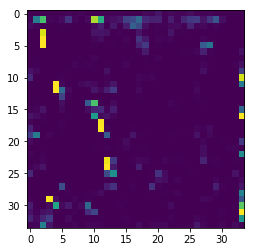

In [531]:
plt.imshow(im_val_pred[0,:,:,0])

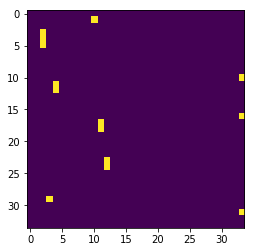

In [532]:
im_val_pred_pups = im_val_pred > 0.8
plt.imshow(im_val_pred_pups[0,:,:,0])

In [609]:
pups_net.predict(np.ones((1, 48*8, 48*8, 3))).shape

(1, 11, 11, 1)

# Create a CNN to get the count

In [799]:
x = pups_net.output
x = Conv2D(64, (11, 11), activation='relu')(x)
count = Conv2D(1, (1, 1), activation='relu')(x)
pups_count_net = Model(inputs=[pups_net.input], outputs=[count])

In [800]:
pups_count_net.predict(np.ones((1, 48*8, 48*8, 3))).shape

(1, 1, 1, 1)

In [801]:
class PupsCountsIterator(Iterator):
    """Iterator yielding training samples of pups
    :param root_dir: Directory containing training images, and dots.
    :param image_ids: Set of image ids to use to sample patches.
    :param class_weights: Weights for each class.
    :param n_samples_per_image: Number of patches to sample on each image.
    :param target_size: Size of the patches sampled.
    :param batch_size: Number of patches sampled per batch
    :param shuffle: Boolean, whether to shuffle the data between epochs.
    :param seed: Random seed for data shuffling.
    :return batch_x, batch_x. 
        batch_x is a (batch_size, target_size[0], target_size[1], 3) array
        batch_x is a (batch_size, target_size[0], target_size[1], 1) array if output_counts is False
        otherwise, it is a (batch_size, 5) array.
    """

    def __init__(self, root_dir, image_ids,
                 class_weights = None,
                 n_samples_per_image=160,
                 target_size=(48*8, 48*8),
                 batch_size=8, shuffle=True, seed=42, debug_dir=None):
        self.n_samples_per_block = 2
        self.n_sealion_types = 5
        self.image_ids = image_ids
        self.root_dir = root_dir
        self.debug_dir = debug_dir
        # Normalize to use class_weights as a probability distribution.
        if class_weights:
            self.class_weights = np.asarray(class_weights)/np.sum(class_weights)
        else:
            self.class_weights = np.ones((self.n_sealion_types+1))/(self.n_sealion_types + 1)
            
        self.n_samples_per_image = n_samples_per_image
        self.target_size = target_size
        self.n_indices = len(self.image_ids) * self.n_samples_per_image
                 
        super(PupsCountsIterator, self).__init__(self.n_indices, batch_size//self.n_samples_per_block, shuffle, seed)
    
    def normalize_input(self, x_bgr):
        x = x_bgr.copy()
        x[..., 0] -= 103.939
        x[..., 1] -= 116.779
        x[..., 2] -= 123.68
        return x
    
    def denormalize_input(self, x_normed):
        x = x_normed.copy()
        x[..., 0] += 103.939
        x[..., 1] += 116.779
        x[..., 2] += 123.68
        return x

    def random_transform(self, im):
        flip_hor = np.random.randint(0, 2)
        flip_ver = np.random.randint(0, 2)
        if flip_hor == 1:
            im = cv2.flip(im, 0)
        if flip_ver == 1:
            im = cv2.flip(im, 1)
        return im
    
    def get_weights(self, dots):
        # Set probability to 0 if some sealion type is not in the block
        current_weigths = self.class_weights.copy()
        for i in range(self.n_sealion_types):
            if not dots[i]:
                current_weigths[i] = 0
        current_weigths /= np.sum(current_weigths)
        return current_weigths
    
    def sample_position(self, shape, dots, current_weigths):
        # Choose an output class randomly
        output_class = np.random.choice(self.n_sealion_types + 1, size=(1, ), p=current_weigths)[0]
        # Sample a location, either for background or for a sealion.
        if output_class == self.n_sealion_types:
            # avoid bg with pups in it
            return self.sample_bg(shape, dots[4]), output_class
        else:
            return self.sample_dot(shape, dots[output_class]), output_class

    def get_dots_in_block(self, bid, shape, dots, target_size=(48*8, 48*8), n_blocks=(4,4), overlap=(448,448)):
        h, w = shape
        w_block = (w + (n_blocks[1] - 1) * overlap[1]) // n_blocks[1]
        h_block = (h + (n_blocks[0] - 1) * overlap[0]) // n_blocks[0]
        
        bx = bid % n_blocks[0]
        by = bid // n_blocks[0]
        
        y_start = by * (h_block - overlap[0])
        y_end = y_start + h_block + 1
        x_start = bx * (w_block - overlap[1])
        x_end = x_start + w_block + 1
        
        dots_in_block = [[] for _ in range(self.n_sealion_types)]
        for i, ds in enumerate(dots):
            for (x, y) in ds:
                if x_start <= x < x_end and y_start <= y < y_end:
                    dots_in_block[i].append((x - x_start, y - y_start))
        return dots_in_block
        
    def get_random_block(self, image_id, shape, dots, current_weigths):
        while True:
            try:
                (x, y), output_class = self.sample_position(shape, dots, current_weigths)
                
                # Get the corresponding image block, and (x, y) in this block
                bid, x, y = get_block_loc(shape, x, y)
                
                # Load the block and check if it is valid
                uid = "{iid}_{bid}".format(iid=image_id, bid=bid)
                img = cv2.imread(os.path.join(self.root_dir, "TrainBlock", uid + ".jpg"))
                if img is not None:
                    dmap_pups = np.load(os.path.join(self.root_dir, "TrainEllipseDensity", uid + ".npz"))['dmap'][:,:,4]
                    return bid, img, dmap_pups
                
            except NonValidPatch:
                continue
        
    
    def sample(self, shape, dots, image_id):
        # if more than 30% of the patch is masked, reject it
        threshold_masked = 0.3 
        
        # If we are stuck on a "bad" block, we retry from scratch
        while True:
            # Set probability to 0 if some sealion type is not in the block
            current_weigths = self.get_weights(dots)
        
            # Get a block randomly (but using the dots and the sampling weights)
            bid, img, dmap_pups = self.get_random_block(image_id, shape, dots, current_weigths)
                
            # Recompute dots in the blocks, and sampling weights
            dots_block = self.get_dots_in_block(bid, shape, dots)
            current_weigths = self.get_weights(dots_block)

            # Now, sample n_samples_per_block patches from it
            n_samples = 0
            bx = np.zeros((self.n_samples_per_block, self.target_size[0], self.target_size[1], 3))
            by = np.zeros((self.n_samples_per_block, ))

            # Stop if we try too many times, 
            max_iterations = self.n_samples_per_block * 5
            current_iteration = 0
            while n_samples < self.n_samples_per_block and current_iteration < max_iterations:
                current_iteration += 1
                try:
                    (x, y), output_class = self.sample_position(img.shape[:2], dots_block, current_weigths)
                    img_patch = img[y:y+self.target_size[0], x:x+self.target_size[1],:]
                    masked_pixels = np.count_nonzero(img_patch == 0)
                    total_pixels = img_patch.shape[0] * img_patch.shape[1]
                    if img_patch.shape[0] != self.target_size[0] or img_patch.shape[1] != self.target_size[1]:
                        continue
                    if masked_pixels/total_pixels < threshold_masked:
                        dmap_pups_patch = dmap_pups[y:y+self.target_size[0], x:x+self.target_size[1]]
                        bx[n_samples, ...] = self.random_transform(img_patch)
                        by[n_samples] = np.sum(dmap_pups_patch)
                        n_samples += 1
                except NonValidPatch:
                    continue
                    
            if current_iteration < max_iterations:
                return bx, by
            # else, we tried too many times, let's get another block.
        
        
    def contains_dots(self, xstart, ystart, dots, margin):
        x1 = xstart - margin
        y1 = ystart - margin
        x2 = xstart + self.target_size[1] + margin
        y2 = ystart + self.target_size[0] + margin
        for (x, y) in dots:
            if x1 <= x < x2 and y1 <= y < y2:
                return True
        return False
    
    def sample_bg(self, shape, dots):
        x = np.random.randint(0, shape[1] - self.target_size[1], size=(1,))[0]
        y = np.random.randint(0, shape[0] - self.target_size[0], size=(1,))[0]
        return x, y
    
    def sample_dot(self, shape, dots):
        margin = 32
        
        rand_index = np.random.choice(len(dots), size=(1,))[0]
        rand_dot = dots[rand_index]
        
        min_x = max(0, rand_dot[0] - self.target_size[1]//2 - margin)
        max_x = min(shape[1] - self.target_size[1], rand_dot[0] - self.target_size[1]//2 + margin)
        
        min_y = max(0, rand_dot[1] - self.target_size[0]//2 - margin)
        max_y = min(shape[0] - self.target_size[0], rand_dot[1] - self.target_size[0]//2 + margin)
        
        if min_x > max_x:
            max_x, min_x = min_x, max_x
        if min_y > max_y:
            max_y, min_y = min_y, max_y 
            
        if min_x == max_x or min_y == max_y:
            raise NonValidPatch()
           
        x = np.random.randint(min_x, max_x, size=(1,))[0]
        y = np.random.randint(min_y, max_y, size=(1,))[0]
        
        return x, y
        
    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
                
        batch_x = np.zeros((current_batch_size * self.n_samples_per_block, self.target_size[0], self.target_size[1], 3), dtype=K.floatx())
        batch_y = np.zeros((current_batch_size * self.n_samples_per_block), dtype=K.floatx())
        
        # For each index, we load the data and sample randomly n_successive_samples patches
        for i, j in enumerate(index_array):
            index = j // self.n_samples_per_image
            image_id = self.image_ids[index]
            with open(os.path.join(self.root_dir, "TrainDots", str(image_id) + ".pkl"), "rb") as pfile:
                dots = pickle.load(pfile)
            with open(os.path.join(self.root_dir, "TrainShape", str(image_id) + ".pkl"), "rb") as pfile:
                shape = pickle.load(pfile)
                
            x, y = self.sample(shape, dots, image_id)
            batch_x[i*self.n_samples_per_block:(i+1)*self.n_samples_per_block, ...] = x
            batch_y[i*self.n_samples_per_block:(i+1)*self.n_samples_per_block] = y 

        if self.debug_dir:
            for i in range(current_batch_size):
                cv2.imwrite(os.path.join(self.debug_dir, "patch_{}.jpg".format(i)), batch_x[i])
                
        permut = np.random.permutation(batch_x.shape[0])
        return self.normalize_input(batch_x[permut, ...]), batch_y[permut,...].reshape((-1, 1, 1, 1))

In [802]:
counts_weights = [1, 1, 1, 1, 5, 0.1]

In [803]:
trainPupsCountsGenerator = PupsCountsIterator("/home/ubuntu/sealion/data/", train_ids, batch_size=8, class_weights=counts_weights)

In [804]:
valPupsCountsGenerator = PupsCountsIterator("/home/ubuntu/sealion/data/", val_ids, batch_size=8, class_weights=counts_weights)

In [805]:
for bx, by in trainPupsCountsGenerator:
    break

In [806]:
bx.shape

(8, 384, 384, 3)

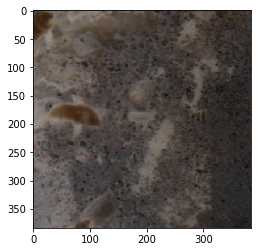

In [807]:
plt.imshow(trainPupsCountsGenerator.denormalize_input(bx)[7])

In [808]:
by

array([[[[ 0.        ]]],


       [[[ 0.        ]]],


       [[[ 0.        ]]],


       [[[ 0.        ]]],


       [[[ 0.99999994]]],


       [[[ 0.        ]]],


       [[[ 0.        ]]],


       [[[ 0.        ]]]], dtype=float32)

In [809]:
for l in pups_count_net.layers:
    l.Trainable = False

In [810]:
for l in pups_count_net.layers[-2:]:
    l.Trainable = True

In [811]:
sgd = SGD(lr=0.0001, momentum=0.9, decay=0.0005, nesterov=True)
pups_count_net.compile(optimizer=sgd, loss=mean_squared_error)

In [812]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

cb_checkpoint_cnt = ModelCheckpoint("/home/ubuntu/data/sealion/data/models/class_pups/ckpt_cnt_{epoch:02d}-{val_loss:.2f}.h5")
cb_reduce_lr_cnt = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', epsilon=0.001, cooldown=0, min_lr=0)
tensorboard_cb_cnt = TensorBoardCallBack(log_dir="/home/ubuntu/data/sealion/data/models/class_pups/log_tb_cnt", batch_freq=10)

In [813]:
h = pups_count_net.fit_generator(trainPupsCountsGenerator, 1000, epochs=5,
                           verbose=1, callbacks=[cb_checkpoint_cnt, cb_reduce_lr_cnt, tensorboard_cb_cnt],
                           validation_data=valPupsCountsGenerator, validation_steps=100,
                           class_weight=None,
                           max_q_size=8, workers=4, pickle_safe=False,
                           initial_epoch=0)

Epoch 1/5
1000/1000 [==============================] - 798s - loss: 9.1383 - val_loss: 4.3083
Epoch 2/5
1000/1000 [==============================] - 713s - loss: 7.6544 - val_loss: 4.6317
Epoch 3/5
1000/1000 [==============================] - 690s - loss: 8.1417 - val_loss: 4.1410
Epoch 4/5
1000/1000 [==============================] - 701s - loss: 6.6185 - val_loss: 4.2448
Epoch 5/5
1000/1000 [==============================] - 706s - loss: 7.0072 - val_loss: 3.0125


In [ ]:
h = pups_count_net.fit_generator(trainPupsCountsGenerator, 1000, epochs=15,
                           verbose=1, callbacks=[cb_checkpoint_cnt, cb_reduce_lr_cnt, tensorboard_cb_cnt],
                           validation_data=valPupsCountsGenerator, validation_steps=100,
                           class_weight=None,
                           max_q_size=8, workers=4, pickle_safe=False,
                           initial_epoch=0)

Epoch 1/15
1000/1000 [==============================] - 698s - loss: 6.0046 - val_loss: 3.2579
Epoch 4/15
 999/1000 [============================>.] - ETA: 0s - loss: 6.0120
Epoch 00003: reducing learning rate to 9.999999747378752e-06.
1000/1000 [==============================] - 700s - loss: 6.0136 - val_loss: 3.1385
Epoch 5/15
1000/1000 [==============================] - 695s - loss: 5.7681 - val_loss: 3.3784
Epoch 6/15
 999/1000 [============================>.] - ETA: 0s - loss: 6.2051
Epoch 00005: reducing learning rate to 9.999999747378752e-07.
1000/1000 [==============================] - 688s - loss: 6.2078 - val_loss: 4.0765
Epoch 7/15
1000/1000 [==============================] - 689s - loss: 6.2535 - val_loss: 4.1894
Epoch 8/15
 205/1000 [=====>........................] - ETA: 497s - loss: 6.5753

KeyboardInterrupt: 

In [845]:
im_val = cv2.imread("/home/ubuntu/sealion/data/TrainBlock/881_13.jpg")
dmap = np.load("/home/ubuntu/sealion/data/TrainEllipseDensity/881_13.npz")["dmap"][:, :, 4]

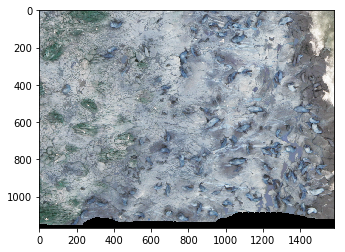

In [846]:
plt.imshow(im_val)

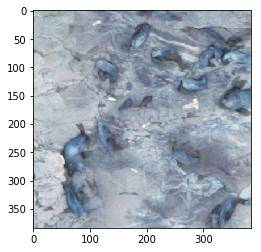

In [865]:
im_val_patch = im_val[0:0+48*8:, 700:700+48*8, :]
im_val_patch = im_val_patch.reshape((1, 48*8, 48*8, 3))
dmap_patch = dmap[0:0+48*8:, 700:700+48*8]
plt.imshow(im_val_patch[0, ...])

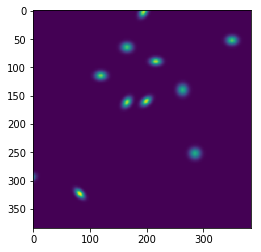

In [868]:
plt.imshow(dmap_patch)

In [869]:
pups_count_net.predict(trainPupsCountsGenerator.normalize_input(im_val_patch.astype(np.float32)))

array([[[[ 8.70702267]]]], dtype=float32)

In [870]:
np.sum(dmap_patch)

9.872592

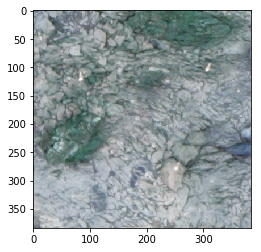

In [871]:
im_val_patch = im_val[:48*8, :48*8, :]
im_val_patch = im_val_patch.reshape((1, 48*8, 48*8, 3))
dmap_patch = dmap[:48*8, :48*8]
plt.imshow(im_val_patch[0, ...])

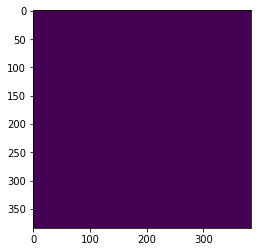

In [833]:
plt.imshow(dmap_patch)

In [834]:
pups_count_net.predict(trainPupsCountsGenerator.normalize_input(im_val_patch.astype(np.float32)))

array([[[[ 0.]]]], dtype=float32)

In [873]:
13/1.5

8.666666666666666

In [883]:
def predict_pups_count(im, net, patchGenerator, patch_size=(384, 384), batch_size=8, overlap=(384//2, 384//2)):
    h, w, c = im.shape
    n_patches_x = int(np.ceil((w - patch_size[1])/(patch_size[1] - overlap[1]) + 1))
    n_patches_y = int(np.ceil((h - patch_size[0])/(patch_size[0] - overlap[0]) + 1))
    print(n_patches_x, n_patches_x)
    
    counts = []
    batch_pos = []
    patch_count = np.zeros((h, w, 1), dtype=np.int8)
    batch_x = np.zeros((batch_size, ) + patch_size + (c, ), dtype=np.float32)
    
    current_batch_size = 0
    for py in range(n_patches_y):
        y_start = py * (patch_size[0] - overlap[0])
        y_start = min(h - patch_size[0], y_start)
        y_end = y_start + patch_size[0]
        for px in range(n_patches_x):
            x_start = px * (patch_size[1] - overlap[1])
            x_start = min(w - patch_size[1], x_start)
            x_end = x_start + patch_size[1]
            
            # Keep filling the batch
            batch_x[current_batch_size, :, :, :] = im[y_start:y_end, x_start:x_end, :]
            batch_pos.append((y_start, y_end, x_start, x_end))
            patch_count[y_start:y_end, x_start:x_end] += 1
            current_batch_size += 1
            
            if current_batch_size == batch_size or (py == n_patches_y - 1 and px == n_patches_x - 1) :
                # time to predict
                batch_x_normed = patchGenerator.normalize_input(batch_x)
                batch_counts = net.predict(batch_x_normed)
                for c in batch_counts:
                    counts.append(c)
                current_batch_size = 0
                
    return counts, batch_pos, patch_count

In [954]:
im_val = cv2.imread("/home/ubuntu/sealion/data/Train/624.jpg")

In [955]:
counts, batch_pos, patch_count = predict_pups_count(im_val, pups_count_net, trainPupsCountsGenerator, overlap=(32, 32))

16 16


In [956]:
sum_cnt = np.sum(counts)
redundancy = np.sum(patch_count)/patch_count.size
print("Final count: ", sum_cnt/redundancy)

Final count:  10.4775050694


In [916]:
import pandas as pd

In [926]:
df = pd.read_csv("/home/ubuntu/data/sealion/data/my_correct_counts.csv")

In [927]:
sval_ids = set(val_ids)

In [928]:
df_val = df[df.train_id.isin(sval_ids)]

In [931]:
df_val.sort_values(by=["pups"], ascending=False)

,train_id,adult_males,subadult_males,adult_females,juveniles,pups
590,590,47,16,322,41,300
338,338,37,7,275,41,248
291,291,39,20,275,23,237
298,298,22,10,172,18,183
847,847,27,3,227,46,151
773,773,28,8,213,5,138
881,881,44,16,173,58,117
240,240,25,8,161,23,113
722,722,19,6,164,7,109
704,704,26,6,167,25,105


In [924]:
df_val.sort_values(by="pups")

KeyError: 'pups'

In [889]:
patch_count.size

16613376

In [836]:
sorted(val_ids)[::-1]

[913,
 906,
 899,
 881,
 880,
 873,
 856,
 851,
 847,
 844,
 840,
 837,
 834,
 831,
 823,
 815,
 810,
 806,
 805,
 804,
 801,
 799,
 786,
 784,
 780,
 777,
 773,
 770,
 762,
 742,
 735,
 722,
 720,
 717,
 713,
 704,
 703,
 700,
 690,
 686,
 682,
 678,
 671,
 659,
 656,
 653,
 652,
 651,
 647,
 637,
 627,
 624,
 623,
 609,
 603,
 602,
 593,
 592,
 590,
 578,
 576,
 569,
 567,
 566,
 558,
 552,
 543,
 542,
 531,
 524,
 505,
 476,
 474,
 470,
 469,
 465,
 463,
 457,
 442,
 435,
 432,
 427,
 425,
 424,
 418,
 412,
 410,
 409,
 397,
 395,
 390,
 389,
 381,
 378,
 377,
 376,
 375,
 374,
 368,
 367,
 366,
 365,
 364,
 355,
 352,
 351,
 349,
 348,
 339,
 338,
 337,
 318,
 316,
 312,
 308,
 303,
 299,
 298,
 297,
 291,
 289,
 287,
 270,
 259,
 252,
 247,
 241,
 240,
 237,
 229,
 221,
 219,
 212,
 210,
 209,
 207,
 203,
 195,
 192,
 181,
 180,
 179,
 178,
 176,
 175,
 173,
 165,
 163,
 158,
 153,
 145,
 143,
 135,
 132,
 130,
 129,
 124,
 118,
 116,
 114,
 78,
 77,
 74,
 68,
 66,
 45,
 36,
 30,
